IMAGE CLASIER PROGRAM ON HUMAN POSES....


In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split="train")

In [3]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

In [5]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=183x275>,
 'labels': 9}

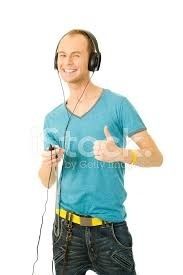

In [6]:
dataset['train'][0]['image']

In [7]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)



{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


IMAGE PREPROCESSING....

In [8]:
from transformers import AutoImageProcessor # <<----this is like the tokenizer for images.

model_checkpoint = "google/vit-base-patch16-224-in21k"
#model_checkpoint = "microsoft/sein2-tiny-patch4-window16-256"

In [9]:
#!pip install --upgrade torch


#!pip install --upgrade torchvision



In [10]:

from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean,std=image_processor.image_std)


size = (image_processor.size['shortest_edge'] if 'shorest_edge' in image_processor.size
        else (image_processor.size['height'], image_processor.size['width']))

transform= Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transformers(batch):
    batch['pixel_values'] = [transform(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

In [11]:
dataset = dataset.with_transform(transform)

EVALUATE THE MODEL.....

## !pip install evaluate

In [12]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



FINE TUNING SECTION FOR IMAGE CLASSIFICATION on THE "VIT"-VISION TRANSFORMER....

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch




In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MODEL TRAINGING SECTION.....

In [15]:

%pip install accelerate -U
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir = "train_dir",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)


Note: you may need to restart the kernel to use updated packages.


In [16]:
trainer.train()

TypeError: Unexpected type <class 'dict'>

In [17]:
trainer.evaluate()

TypeError: Unexpected type <class 'dict'>

In [18]:
trainer.save_model("vit-human-pose-classification")

CLASSIFICATION REPORT AND CONFUSION MATRIX....



In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [24]:
logits = trainer.predict(dataset['test'])

TypeError: Unexpected type <class 'dict'>

In [25]:
logits = logits.predcitions

NameError: name 'logits' is not defined

In [30]:
y_pred = np.argmax(logits, axis=1)




NameError: name 'logits' is not defined

In [31]:
y_true = [x['lables'] for x in dataset['test']]

TypeError: Unexpected type <class 'dict'>

In [32]:
print(classification_report(y_true, y_pred, target_names= labels))

NameError: name 'y_true' is not defined

In [33]:
cm= confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklables=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

NameError: name 'y_true' is not defined

PREDICTION ON REAL IMAGE IN THE REAL WORLD FROM ANYWHERE. Pay attention to the url variable where I got the image from.

In [ ]:
from transformers import pipeline
from transformers import AutoImageProcessor

model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint, use_fast = True)   ### this is the tokenizer for images...

pipe = pipeline('image-classification', model='vit-human-pose=-classification',
                image_processor=image_processor)

url = "https://images.pexels.com/photos/1755385/pexels-photo.jpeg"

output = pipe(url)

output



PUSH MODEL TO AWS S3 BUCKET....

In [36]:
import os
import boto3

s3 = boto3.client("s3")
bucket_name = 'mlopsmorris'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key  = os.path.join(s3_prefix, relpath).replace("\\","/")

            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory("vit-human-pose-classification", "ml-models/vit-human-pose-classification")





NoCredentialsError: Unable to locate credentials